In [ ]:
import argparse
import os

import numpy as np
import pandas as pd
from tqdm import tqdm

INF_STR = "{:10d} entries {:7d} users {:7d} items for {}"

parser = argparse.ArgumentParser()

parser.add_argument('--listening_history_path', '-lh', type=str,
                    help="Path to 'users.tsv' and 'listening_events.tsv' of the LFM2b-2020 dataset.")
parser.add_argument('--saving_path', '-s', type=str, help="Path where to save the split data. Default to './'",
                    default='./')

args = parser.parse_args()

listening_history_path = args.listening_history_path
saving_path = args.saving_path
k = 1

user_info_path = os.path.join(listening_history_path, 'users.tsv')
item_info_path = os.path.join(listening_history_path, 'tracks.tsv')
listening_events_path = os.path.join(listening_history_path, 'listening_events.tsv')

lhs = pd.read_csv(listening_events_path, sep='\t', names=['old_user_id', 'old_item_id', 'timestamp'], skiprows=1,
                  usecols=[0, 1, 3])
print(INF_STR.format(len(lhs), lhs.old_user_id.nunique(), lhs.old_item_id.nunique(), 'Original Data'))

# We keep only the data from the last month
lhs = lhs[lhs.timestamp >= '2020-02-20 00:00:00']
print(INF_STR.format(len(lhs), lhs.old_user_id.nunique(), lhs.old_item_id.nunique(), 'Only last month'))

# Loading users and items
users = pd.read_csv(user_info_path, delimiter='\t', names=['old_user_id', 'country', 'age', 'gender', 'creation_time'],
                    skiprows=1)

# Only users with gender in m/f and 10 <= age <= 95
users = users[(users.gender.isin(['m', 'f'])) & (users.age >= 10) & (users.age <= 95)]
lhs = lhs[lhs.old_user_id.isin(set(users.old_user_id))]
print(INF_STR.format(len(lhs), lhs.old_user_id.nunique(), lhs.old_item_id.nunique(),
                     'Only users with gender and valid age'))

# Keeping only the first interaction
lhs = lhs.sort_values('timestamp')
lhs = lhs.drop_duplicates(subset=['old_user_id', 'old_item_id'])
print(INF_STR.format(len(lhs), lhs.old_user_id.nunique(), lhs.old_item_id.nunique(),
                     'Keeping only the first interaction'))

# Removing power users
user_counts = lhs.old_user_id.value_counts()
perc_99 = np.percentile(user_counts, 99)
user_below = set(user_counts[user_counts <= perc_99].index)
lhs = lhs[lhs.old_user_id.isin(user_below)]

print(INF_STR.format(len(lhs), lhs.old_user_id.nunique(), lhs.old_item_id.nunique(),
                     'Removed power users (below the 99% percentile)'))

# 10-core filtering
while True:
    start_number = len(lhs)

    # Item pass
    item_counts = lhs.old_item_id.value_counts()
    item_above = set(item_counts[item_counts >= 10].index)
    lhs = lhs[lhs.old_item_id.isin(item_above)]
    print('Records after item pass: ', len(lhs))

    # User pass
    user_counts = lhs.old_user_id.value_counts()
    user_above = set(user_counts[user_counts >= 10].index)
    lhs = lhs[lhs.old_user_id.isin(user_above)]
    print('Records after user pass: ', len(lhs))

    if len(lhs) == start_number:
        print('Exiting...')
        break

print(INF_STR.format(len(lhs), lhs.old_user_id.nunique(), lhs.old_item_id.nunique(), '10-core filtering'))

# Creating simple integer indexes used for sparse matrices
user_ids = lhs.old_user_id.drop_duplicates().reset_index(drop=True)
item_ids = lhs.old_item_id.drop_duplicates().reset_index(drop=True)
user_ids.index.name = 'user_id'
item_ids.index.name = 'item_id'
user_ids = user_ids.reset_index()
item_ids = item_ids.reset_index()
lhs = lhs.merge(user_ids).merge(item_ids)

print('Splitting the data, temporal ordered - leave-k-out.')

lhs = lhs.sort_values('timestamp')
train_idxs = []
val_idxs = []
test_idxs = []
for user, user_group in tqdm(lhs.groupby('old_user_id')):
    # Data is already sorted by timestamp
    if len(user_group) <= k * 2:
        # Not enough data for val/test data. Place the user in train.
        train_idxs += (list(user_group.index))
    else:
        train_idxs += list(user_group.index[:-2 * k])
        val_idxs += list(user_group.index[-2 * k:-k])
        test_idxs += list(user_group.index[-k:])

train_data = lhs.loc[train_idxs]
val_data = lhs.loc[val_idxs]
test_data = lhs.loc[test_idxs]

print(INF_STR.format(len(train_data), train_data.old_user_id.nunique(), train_data.old_item_id.nunique(), 'Train Data'))
print(INF_STR.format(len(val_data), val_data.old_user_id.nunique(), val_data.old_item_id.nunique(), 'Val Data'))
print(INF_STR.format(len(test_data), test_data.old_user_id.nunique(), test_data.old_item_id.nunique(), 'Test Data'))

# Saving locally

print('Saving data to {}'.format(saving_path))

train_data.to_csv(os.path.join(saving_path, 'listening_history_train.csv'), index=False)
val_data.to_csv(os.path.join(saving_path, 'listening_history_val.csv'), index=False)
test_data.to_csv(os.path.join(saving_path, 'listening_history_test.csv'), index=False)

user_ids.to_csv(os.path.join(saving_path, 'user_ids.csv'), index=False)
item_ids.to_csv(os.path.join(saving_path, 'item_ids.csv'), index=False)

# Step 1. Filtering out the data from 2019-01-01 to 2019-04-01

In [41]:
import pandas as pd
import logging
import os

logging.getLogger().setLevel(logging.INFO)

file_name = "../artifacts/data_ingestion/lfm_2b/listening-events.tsv"
prefix_path = "../artifacts/data_ingestion/lfm_2b/filter"
chunksize = 10**8
min_play_date = pd.to_datetime("2019-01-01 00:00:00")
max_play_time = pd.to_datetime("2019-04-01 00:00:00")

columns = ["user_id", "track_id", "timestamp"]

chunk_index = 0
for chunk in pd.read_csv(file_name, sep="\t", chunksize=chunksize):
    logging.info(f"""reading from {chunk.index.min()} to {chunk.index.max()}""")
    chunk["timestamp"] = pd.to_datetime(chunk["timestamp"], format="%Y-%m-%d %H:%M:%S")
    chunk = chunk.loc[(chunk["timestamp"] >= min_play_date), :]
    chunk = chunk.loc[(chunk["timestamp"] < max_play_time), :]

    if len(chunk) > 0:
        logging.info(f"""writing from {chunk.index.min()} to {chunk.index.max()}""")

        chunk_path = os.path.join(prefix_path, f"""{int(chunk_index)}_two_month.parquet""")
        chunk = chunk[columns]
        chunk.to_parquet(chunk_path, index=False)
        logging.info(f"""writing chunk to {chunk_path} finished""")
        chunk_index += 1
    logging.info(f"""#################################""")

[ 2025-10-27 15:36:56,611 ]: INFO root 3068622617 17:-> reading from 0 to 99999999
[ 2025-10-27 15:37:57,835 ]: INFO root 3068622617 30:-> #################################
[ 2025-10-27 15:39:08,422 ]: INFO root 3068622617 17:-> reading from 100000000 to 199999999
[ 2025-10-27 15:40:09,483 ]: INFO root 3068622617 30:-> #################################
[ 2025-10-27 15:41:18,732 ]: INFO root 3068622617 17:-> reading from 200000000 to 299999999
[ 2025-10-27 15:42:23,277 ]: INFO root 3068622617 30:-> #################################
[ 2025-10-27 15:43:35,388 ]: INFO root 3068622617 17:-> reading from 300000000 to 399999999
[ 2025-10-27 15:44:41,961 ]: INFO root 3068622617 30:-> #################################
[ 2025-10-27 15:45:56,336 ]: INFO root 3068622617 17:-> reading from 400000000 to 499999999
[ 2025-10-27 15:46:57,011 ]: INFO root 3068622617 30:-> #################################
[ 2025-10-27 15:48:04,853 ]: INFO root 3068622617 17:-> reading from 500000000 to 599999999
[ 2025-

# Step 2. Concatination of all the data from 2019-01-01 to 2019-04-01

In [60]:
import pandas as pd
import logging
import os

logging.getLogger().setLevel(logging.INFO)

prefix_path = "../artifacts/data_ingestion/lfm_2b/filter"
list_of_dataframes = []

for i in range(100):
    chunk_path = os.path.join(prefix_path, f"""{int(i)}_two_month.parquet""")
    if os.path.exists(chunk_path):
        logging.info(f"""reading chunk from {chunk_path}""")
        chunk_data = pd.read_parquet(chunk_path)
        list_of_dataframes.append(chunk_data)

logging.info(f"""Writing data of 2019 to 2020 to disk""")
all_three_month_data = pd.concat(list_of_dataframes, ignore_index=True)

[ 2025-10-27 17:25:54,314 ]: INFO root 1107853707 13:-> reading chunk from ../artifacts/data_ingestion/lfm_2b/filter\0_two_month.parquet
[ 2025-10-27 17:25:54,336 ]: INFO root 1107853707 13:-> reading chunk from ../artifacts/data_ingestion/lfm_2b/filter\1_two_month.parquet
[ 2025-10-27 17:25:54,431 ]: INFO root 1107853707 13:-> reading chunk from ../artifacts/data_ingestion/lfm_2b/filter\2_two_month.parquet
[ 2025-10-27 17:25:54,508 ]: INFO root 1107853707 13:-> reading chunk from ../artifacts/data_ingestion/lfm_2b/filter\3_two_month.parquet
[ 2025-10-27 17:25:54,665 ]: INFO root 1107853707 13:-> reading chunk from ../artifacts/data_ingestion/lfm_2b/filter\4_two_month.parquet
[ 2025-10-27 17:25:54,762 ]: INFO root 1107853707 13:-> reading chunk from ../artifacts/data_ingestion/lfm_2b/filter\5_two_month.parquet
[ 2025-10-27 17:25:54,847 ]: INFO root 1107853707 13:-> reading chunk from ../artifacts/data_ingestion/lfm_2b/filter\6_two_month.parquet
[ 2025-10-27 17:25:54,930 ]: INFO root 11

In [ ]:
user_info_path = os.path.join("../artifacts/data_ingestion/lfm_2b", "users.tsv")
users = pd.read_csv(
    user_info_path, delimiter="\t", names=["user_id", "country", "age", "gender", "creation_time"], skiprows=1
)

# Only users with gender in m/f and 10 <= age <= 95
users = users[(users.gender.isin(["m", "f"])) & (users.age >= 10) & (users.age <= 95)]

logging.info(f"""The number of users before filtering the valid users is: {len(all_three_month_data["user_id"].unique())}""")

mask = all_three_month_data["user_id"].isin(users["user_id"].unique())
all_three_month_data = all_three_month_data[mask]
logging.info(f"""The number of users after filtering the valid users is: {len(all_three_month_data["user_id"].unique())}""")


all_three_month_data.to_parquet("../artifacts/data_ingestion/lfm_2b/filter/all_data.parquet", index=False)

[ 2025-10-27 17:27:57,907 ]: INFO root 3431293283 9:-> The number of users before filtering the valid users is: 16170
[ 2025-10-27 17:27:58,850 ]: INFO root 3431293283 13:-> The number of users after filtering the valid users is: 10565


In [64]:
logging.info(f"""The number of events after filtering the valid users: {len(all_three_month_data)}""")
logging.info(f"""The number of users after filtering the valid users: {len(all_three_month_data["user_id"].unique())}""")
logging.info(f"""The number of unique tracks after filtering the valid users: {len(all_three_month_data["track_id"].unique())}""")

[ 2025-10-27 17:29:45,814 ]: INFO root 1265552493 1:-> The number of events after filtering the valid users: 23117575
[ 2025-10-27 17:29:46,020 ]: INFO root 1265552493 2:-> The number of users after filtering the valid users: 10565
[ 2025-10-27 17:29:47,324 ]: INFO root 1265552493 3:-> The number of unique tracks after filtering the valid users: 3302632


### Counting the number of unique days that users played at least one track in the three months preiod

In [ ]:
import pandas as pd
import os
from tqdm.autonotebook import tqdm

user_dic_2019 = {}

all_three_month_data = pd.read_parquet("../artifacts/data_ingestion/lfm_2b/filter/all_data.parquet")
all_three_month_data["timestamp"] = all_three_month_data.timestamp.dt.strftime("%Y-%m-%d")
all_three_month_data = all_three_month_data.drop_duplicates(["user_id", "timestamp"])
all_three_month_data = all_three_month_data.set_index("user_id")
all_user_ids = all_three_month_data.index.unique()
for user_id in tqdm(all_user_ids, position=1, leave=False):
    user_time_stamps = all_three_month_data.loc[[user_id]]["timestamp"].values
    time_stamps_set = user_dic_2019.get(user_id, set())
    time_stamps_set.update(set(user_time_stamps))
    user_dic_2019[user_id] = time_stamps_set

In [66]:
import sys
sys.path.append("../src")

from reytools.read_write import write_json
from pathlib import Path


for user_id in user_dic_2019.keys():
    values = user_dic_2019[user_id]
    user_dic_2019[user_id] = list(values)

write_path = Path(os.path.join("../artifacts/data_ingestion/lfm_2b/filter", "three_month_users.json"))
write_json(write_path, user_dic_2019)
print(len(user_dic_2019))

[ 2025-10-27 17:56:49,263 ]: INFO root _read_write 51:-> json data saved to: ..\artifacts\data_ingestion\lfm_2b\filter\three_month_users.json
10565


,user_id,n_days
0,5767,82
1,15754,42
2,1680,83
3,2565,24
4,56041,67


10565


<Axes: xlabel='n_days', ylabel='Count'>

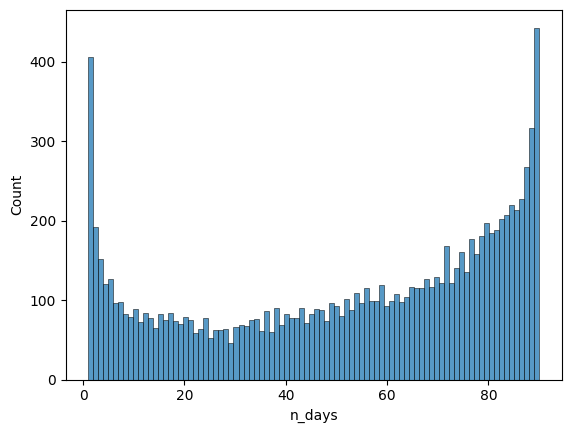

In [67]:
import sys
import os
import pandas as pd
import seaborn as sns

user_count_dic = {}
for user_id in user_dic_2019.keys():
    user_count_dic[user_id] = len(user_dic_2019[user_id])

user_count_df = pd.DataFrame(zip(user_count_dic.keys(), user_count_dic.values()), columns=["user_id", "n_days"])
display(user_count_df.head())
print(len(user_count_df["user_id"].unique()))
sns.histplot(user_count_df, x="n_days", bins=90)

# Step 3. Spliting the data to three chunks to find users who played tracks in all three months.  

In [ ]:
import pandas as pd

first_month_date = pd.to_datetime("2019-01-01 00:00:00")
second_month_date = pd.to_datetime("2019-02-01 00:00:00")
third_month_date = pd.to_datetime("2019-03-01 00:00:00")

all_three_month_data = pd.read_parquet("../artifacts/data_ingestion/lfm_2b/filter/all_data.parquet")

mask = (all_three_month_data.timestamp >= first_month_date) & (all_three_month_data.timestamp < second_month_date)
month_1 = all_three_month_data[mask].copy()

mask = (all_three_month_data.timestamp >= second_month_date) & (all_three_month_data.timestamp < third_month_date)
month_2 = all_three_month_data[mask].copy()

mask = (all_three_month_data.timestamp >= third_month_date)
month_3 = all_three_month_data[mask].copy()

users_1 = set(month_1["user_id"].unique())
users_2 = set(month_2["user_id"].unique())
users_3 = set(month_3["user_id"].unique())

all_valid_users = users_1.intersection(users_2).intersection(users_3)
logging.info(f"""The number of users that are common in three months is: {len(all_valid_users)}""")

mask = all_three_month_data["user_id"].isin(all_valid_users)
all_three_month_data = all_three_month_data[mask]
all_three_month_data.to_parquet("../artifacts/data_ingestion/lfm_2b/filter/all_data_filtered_1.parquet", index=False)


[ 2025-10-27 18:36:51,736 ]: INFO root 1416492719 23:-> The number of users that are common in three months is: 8988


# Step 4. Filtering the users who listened to tracks in 20 days of each month  

In [1]:
import pandas as pd
import os
from tqdm.autonotebook import tqdm

def get_n_play_days_of_users(dataset):
    user_dic = {}
    dataset["timestamp"] = dataset.timestamp.dt.strftime("%Y-%m-%d")
    dataset = dataset.drop_duplicates(["user_id", "timestamp"])
    dataset = dataset.set_index("user_id")
    all_user_ids = dataset.index.unique()
    for user_id in tqdm(all_user_ids, position=1, leave=False):
        user_time_stamps = dataset.loc[[user_id]]["timestamp"].values
        time_stamps_set = user_dic.get(user_id, set())
        time_stamps_set.update(set(user_time_stamps))
        user_dic[user_id] = time_stamps_set
    
    user_count_dic = {}
    for user_id in user_dic.keys():
        user_count_dic[user_id] = len(user_dic[user_id])

    user_count_df = pd.DataFrame(zip(user_count_dic.keys(), user_count_dic.values()), columns=["user_id", "n_days"])
    return user_count_df

C:\Users\sazeh\AppData\Local\Temp\ipykernel_11572\4125696578.py:3: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


### Stap 4.1. For each user, we find the number of days that they played tracks in them.  

In [2]:
first_month_date = pd.to_datetime("2019-01-01 00:00:00")
second_month_date = pd.to_datetime("2019-02-01 00:00:00")
third_month_date = pd.to_datetime("2019-03-01 00:00:00")

all_three_month_data = pd.read_parquet("../artifacts/data_ingestion/lfm_2b/filter/all_data_filtered_1.parquet")

mask = (all_three_month_data.timestamp >= first_month_date) & (all_three_month_data.timestamp < second_month_date)
month_1 = all_three_month_data[mask].copy()

mask = (all_three_month_data.timestamp >= second_month_date) & (all_three_month_data.timestamp < third_month_date)
month_2 = all_three_month_data[mask].copy()

mask = (all_three_month_data.timestamp >= third_month_date)
month_3 = all_three_month_data[mask].copy()

user_count_df_1 = get_n_play_days_of_users(month_1)
user_count_df_2 = get_n_play_days_of_users(month_2)
user_count_df_3 = get_n_play_days_of_users(month_3)


<Axes: xlabel='n_days', ylabel='Count'>

<Axes: xlabel='n_days', ylabel='Count'>

<Axes: xlabel='n_days', ylabel='Count'>

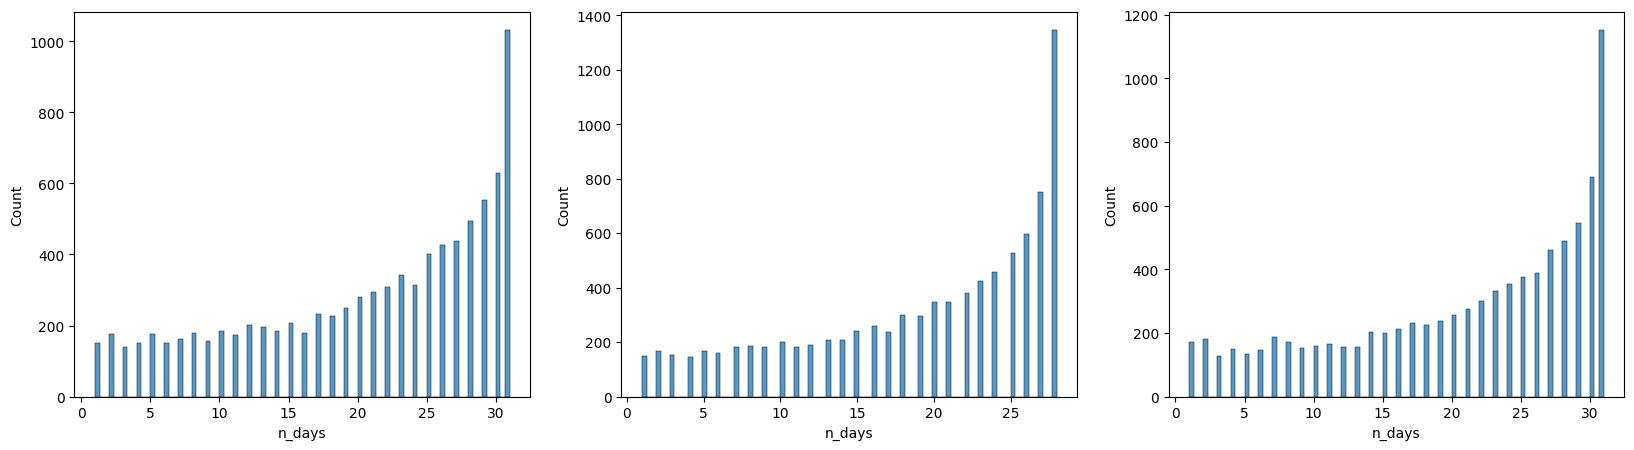

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

display(sns.histplot(user_count_df_1, x="n_days", bins=90, ax=axes.ravel()[0]))
display(sns.histplot(user_count_df_2, x="n_days", bins=90, ax=axes.ravel()[1]))
display(sns.histplot(user_count_df_3, x="n_days", bins=90, ax=axes.ravel()[2]))

In [ ]:
import numpy as np
import logging 

logging.getLogger().setLevel(logging.INFO)

mask = user_count_df_1["n_days"] >= 20
user_set_1 = set(user_count_df_1[mask]["user_id"].unique())

mask = user_count_df_2["n_days"] >= 20
user_set_2 = set(user_count_df_2[mask]["user_id"].unique())

mask = user_count_df_3["n_days"] >= 20
user_set_3 = set(user_count_df_3[mask]["user_id"].unique())

last_valid_users = user_set_1.intersection(user_set_2).intersection(user_set_3)

logging.info(f"""The number of unique users after filtering min days playing in month 1 is: {len(user_set_1)}""")
logging.info(f"""The number of unique users after filtering min days playing in month 2 is: {len(user_set_2)}""")
logging.info(f"""The number of unique users after filtering min days playing in month 3 is: {len(user_set_3)}""")
logging.info(f"""The number of unique common users in all three months: {len(last_valid_users)}""")

INFO:root:The number of unique users after filtering min days playing in month 1 is: 5511
INFO:root:The number of unique users after filtering min days playing in month 2 is: 5181
INFO:root:The number of unique users after filtering min days playing in month 3 is: 5615
INFO:root:The number of unique common users in all three months: 4304


# Step 5. Filtering out all the remained valid users from the original dataset

In [ ]:
all_three_month_data = pd.read_parquet("../artifacts/data_ingestion/lfm_2b/filter/all_data.parquet", index=False)
mask = all_three_month_data["user_id"].isin(last_valid_users)

all_three_month_data = all_three_month_data[mask].copy()
all_three_month_data.to_parquet("../artifacts/data_ingestion/lfm_2b/filter/final_valid_data.parquet", index=False)


logging.info(f"""The number of final events after final filtering: {len(all_three_month_data)}""")
logging.info(f"""The number of filal users after final filtering: {len(all_three_month_data["user_id"].unique())}""")
logging.info(f"""The number of final unique tracks after final filtering: {len(all_three_month_data["track_id"].unique())}""")

INFO:root:The number of final events after final filtering: 17175734
INFO:root:The number of fila users after final filtering: 4304
INFO:root:The number of unique tracks after final filtering: 2598104


# Step 6. Selecting 1000 users randomly  

In [33]:
import pandas as pd
import numpy as np
import logging

logging.getLogger().setLevel(logging.INFO)

filtered_data = pd.read_parquet("../artifacts/data_ingestion/lfm_2b/filter/final_valid_data.parquet")
filtered_data = filtered_data.reset_index(drop=True)

remained_users = list(set(filtered_data["user_id"].unique()))

rng = np.random.RandomState(42)
sampled_items = 1000
rng.shuffle(remained_users)

selected_users = remained_users[:sampled_items]

mask = filtered_data["user_id"].isin(selected_users)
selected_data = filtered_data[mask]
selected_data.to_parquet("../artifacts/data_ingestion/lfm_2b/filter/1000_users_data.parquet", index=False)
selected_tracks = set(filtered_data["track_id"].unique())

logging.info(f"""The number of final events after random selection: {len(selected_data)}""")
logging.info(f"""The number of filal users after random selection: {len(selected_data["user_id"].unique())}""")
logging.info(f"""The number of final unique tracks after random selection: {len(selected_data["track_id"].unique())}""")

[ 2025-10-28 16:34:01,388 ]: INFO root 4274165267 23:-> The number of final events after random selection: 4012812
[ 2025-10-28 16:34:01,420 ]: INFO root 4274165267 24:-> The number of filal users after random selection: 1000
[ 2025-10-28 16:34:01,544 ]: INFO root 4274165267 25:-> The number of final unique tracks after random selection: 938577


# Step 7. Finding all the tracks of selected users that played until 2019-04-01 for creating users Base Profiles

In [1]:
import os
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

base_start_date = pd.to_datetime("2019-01-01 00:00:00")
base_end_date = pd.to_datetime("2019-02-01 00:00:00")

current_start_date = pd.to_datetime("2019-02-01 00:00:00")
current_end_date = pd.to_datetime("2019-02-11 00:00:00")

all_three_month_data = pd.read_parquet("../artifacts/data_ingestion/lfm_2b/filter/all_data.parquet")

mask = (all_three_month_data["timestamp"] >= base_start_date) & (all_three_month_data["timestamp"] < current_end_date)

base_current_data = all_three_month_data[mask]
base_current_data = base_current_data.reset_index(drop=True)

rating_df = base_current_data.groupby(['user_id', 'track_id']).size().reset_index(name='rating')
rating_df = rating_df.rename(columns={"user_id":"user", "track_id":"item"})

d:\Reza\thesis\codes\python2\Calibration\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import sys

if(1):
    sys.path.append("../")
    sys.path.append("../src")

from src.tools import create_user_item_map
from src.tools import generate_user_item_matrix
from src.tools import group_items_based_popularity
from src.tools import calc_item_popularity

user_map, item_map = create_user_item_map(rating_df)
sparse_matrix = generate_user_item_matrix(rating_df, user_map, item_map)
item_popularity = calc_item_popularity(sparse_matrix)
item_groups = group_items_based_popularity(item_popularity, proportions=[0.2, 0.6, 0.2])

### generating base and current profile of each user

In [4]:
import logging
logging.getLogger().setLevel(logging.INFO)

base_start_date = pd.to_datetime("2019-01-01 00:00:00")
base_end_date = pd.to_datetime("2019-02-01 00:00:00")

current_start_date = pd.to_datetime("2019-02-01 00:00:00")
current_end_date = pd.to_datetime("2019-02-11 00:00:00")

selected_users_data = pd.read_parquet("../artifacts/data_ingestion/lfm_2b/filter/1000_users_data.parquet")

mask = (selected_users_data["timestamp"] >= base_start_date) & (selected_users_data["timestamp"] < base_end_date)
base_data = selected_users_data[mask]

mask = (selected_users_data["timestamp"] >= current_start_date) & (selected_users_data["timestamp"] < current_end_date)
current_data = selected_users_data[mask]

rating_base = base_data.groupby(['user_id', 'track_id']).size().reset_index(name='rating')
rating_base = rating_base.rename(columns={"user_id":"user", "track_id":"item"})

rating_current = current_data.groupby(['user_id', 'track_id']).size().reset_index(name='rating')
rating_current = rating_current.rename(columns={"user_id":"user", "track_id":"item"})

logging.info(f"""Base Profile: #items: {rating_base.item.nunique()}, #users: {rating_base.user.nunique()} """)
logging.info(f"""Current Profile: #items: {rating_current.item.nunique()}, #users: {rating_current.user.nunique()} """)

[ 2025-10-28 17:05:35,551 ]: INFO root 2002494327 24:-> Base Profile: #items: 469365, #users: 1000 
[ 2025-10-28 17:05:35,567 ]: INFO root 2002494327 25:-> Current Profile: #items: 214197, #users: 1000 


In [5]:
new_user_map, _ = create_user_item_map(rating_base)

profile_base = generate_user_item_matrix(rating_base, new_user_map, item_map)
profile_current = generate_user_item_matrix(rating_current, new_user_map, item_map)

display(profile_base.shape)
display(profile_current.shape)

(1000, 2080065)

(1000, 2080065)

# Analyzing the Dataset

In [10]:
from src.reylearn.metrics.probability import jsd, kl_divergence
from src.tools import calculate_pc

p_c_ordered = calculate_pc(profile_base.toarray(), item_groups)
q_c_ordered = calculate_pc(profile_current.toarray(), item_groups)

np.float64(0.12329568688614162)

In [11]:
user_kl = kl_divergence(p_c_ordered, q_c_ordered)
print(user_kl.mean())

user_jsd = jsd(p_c_ordered, q_c_ordered)
print(user_jsd.mean())

0.12329568688614162
0.021166617860393297


In [39]:
p = np.array([[0.33112583, 0.64238411, 0.02649007], [0.08856089, 0.76937269, 0.14206642]])
q = np.array([[0.74339623, 0.25660377, 0.0], [0.34831461, 0.65168539, 0.0]])

epsilon: float = 1e-12
q_smoothed = q + epsilon
p_smoothed = p + epsilon

# to prevention of unstable calculation
q_smoothed = q_smoothed / np.sum(q_smoothed, axis=1, keepdims=True)
p_smoothed = p_smoothed / np.sum(p_smoothed, axis=1, keepdims=True)


# print(p_smoothed)
# print(q_smoothed)

ratio = p_smoothed / q_smoothed
np.sum(p * np.log2(ratio), axis=1)

array([1.38131828, 5.27254957])

In [43]:
print(np.argsort(user_kl)[::-1][:10])
print(user_kl[np.argsort(user_kl)[::-1][:10]])
print(user_jsd[np.argsort(user_kl)[::-1][:10]])
# print(p_c_ordered[np.argsort(user_kl)[::-1][:10]])
# print(q_c_ordered[np.argsort(user_kl)[::-1][:10]])


[986 691 864 158 873 713 884  84 789 964]
[5.99636425 5.2725496  4.33854243 3.8434978  2.81603443 2.55214264
 2.55022009 2.48109387 1.6438019  1.38131813]
[0.09482908 0.13411538 0.09000987 0.06696643 0.54861166 0.0823718
 0.09068953 0.05644206 0.03848728 0.13347716]


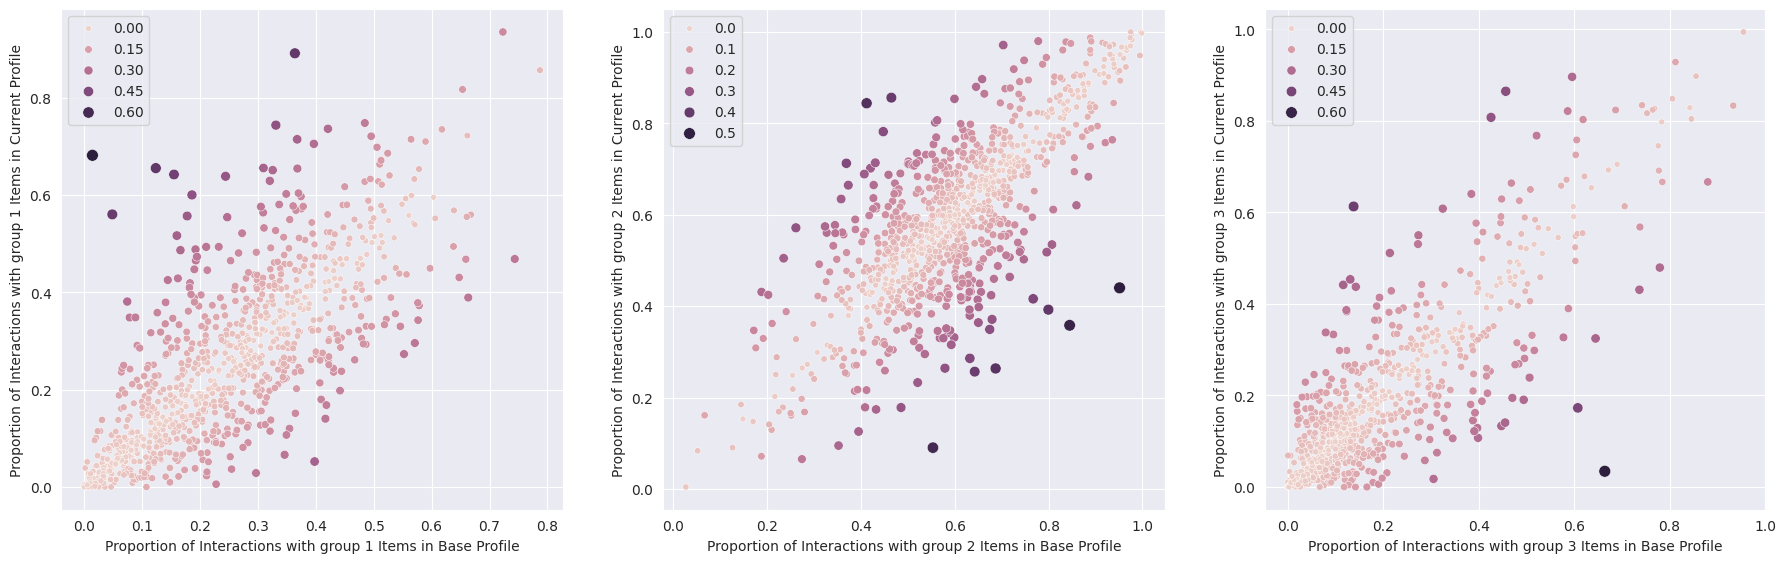

In [41]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

with sns.axes_style("darkgrid"):
    fig, axes = plt.subplots(1, 3, figsize=(22, 6.5))
    for i in range(3):
        ax = axes[i]
        diff_ordered = np.abs(p_c_ordered[:, i] - q_c_ordered[:, i])
        sns.scatterplot(x=p_c_ordered[:, i], y=q_c_ordered[:, i], size=diff_ordered, hue=diff_ordered, ax=ax)
        
        label_x = f"Proportion of Interactions with group {i+1} Items in Base Profile"
        label_y = f"Proportion of Interactions with group {i+1} Items in Current Profile"
        
        ax.set_xlabel(label_x)
        ax.set_ylabel(label_y)


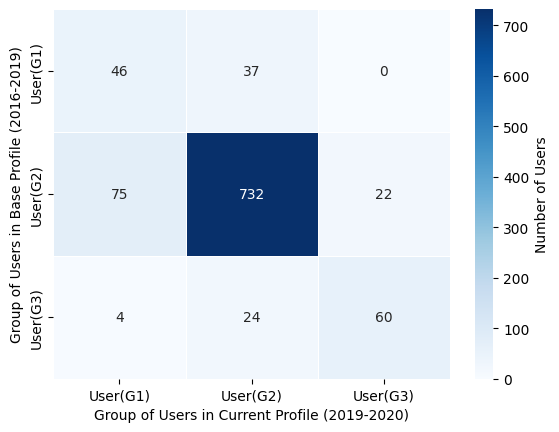

In [44]:
user_consumption_type_before = np.argmax(p_c_ordered, axis=1)
user_consumption_type_after = np.argmax(q_c_ordered, axis=1)

n_groups = p_c_ordered.shape[1]
transition_matrix = np.zeros((n_groups, n_groups), dtype=int)

for i in range(n_groups):
    for j in range(n_groups):
        count = np.sum((user_consumption_type_before == i) & (user_consumption_type_after == j))
        transition_matrix[i, j] = count

group_labels = ["User(G1)", "User(G2)", "User(G3)"]
df_transition = pd.DataFrame(transition_matrix, index=group_labels, columns=group_labels)


sns.heatmap(df_transition, annot=True, fmt="d", cmap="Blues", linewidths=0.5, cbar_kws={"label": "Number of Users"})

plt.ylabel("Group of Users in Base Profile (2016-2019)")
plt.xlabel("Group of Users in Current Profile (2019-2020)")

plt.show()

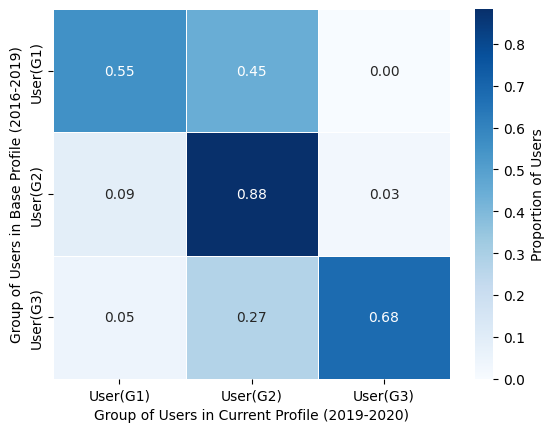

In [45]:
user_consumption_type_before = np.argmax(p_c_ordered, axis=1)
user_consumption_type_after = np.argmax(q_c_ordered, axis=1)

n_groups = p_c_ordered.shape[1]
transition_matrix = np.zeros((n_groups, n_groups), dtype=int)

for i in range(n_groups):
    for j in range(n_groups):
        count = np.sum((user_consumption_type_before == i) & (user_consumption_type_after == j))
        transition_matrix[i, j] = count

# Normalize rows (convert counts to proportions)
transition_matrix_normalized = transition_matrix / transition_matrix.sum(axis=1, keepdims=True)

group_labels = ["User(G1)", "User(G2)", "User(G3)"]
df_transition = pd.DataFrame(transition_matrix_normalized, index=group_labels, columns=group_labels)

sns.heatmap(df_transition, annot=True, fmt=".2f", cmap="Blues", linewidths=0.5, cbar_kws={"label": "Proportion of Users"})
plt.ylabel("Group of Users in Base Profile (2016-2019)")
plt.xlabel("Group of Users in Current Profile (2019-2020)")
plt.show()

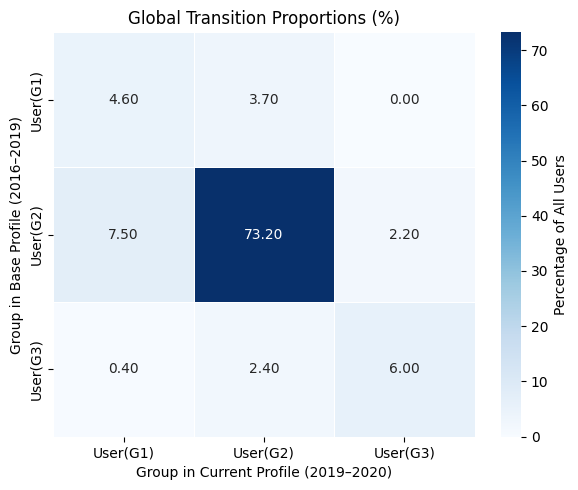

In [47]:
group_labels = [f"User(G{i+1})" for i in range(n_groups)]

# ----------------------------------------------------------
# 1. Hard assign each user to its main group
# ----------------------------------------------------------
user_before = np.argmax(p_c_ordered, axis=1)
user_after  = np.argmax(q_c_ordered, axis=1)

# ----------------------------------------------------------
# 2. Build raw transition counts
# ----------------------------------------------------------
transition_matrix = np.zeros((n_groups, n_groups), dtype=int)
for i in range(n_groups):
    for j in range(n_groups):
        transition_matrix[i, j] = np.sum((user_before == i) & (user_after == j))

# ----------------------------------------------------------
# 3. Normalize by total number of users (global proportions)
# ----------------------------------------------------------
transition_matrix_percent = transition_matrix / transition_matrix.sum()

# ----------------------------------------------------------
# 4. Plot heatmap
# ----------------------------------------------------------
df_transition = pd.DataFrame(
    transition_matrix_percent,
    index=group_labels,
    columns=group_labels
)

plt.figure(figsize=(6, 5))
sns.heatmap(
    df_transition * 100, annot=True, fmt=".2f", cmap="Blues",
    linewidths=0.5, cbar_kws={"label": "Percentage of All Users"}
)
plt.ylabel("Group in Base Profile (2016–2019)")
plt.xlabel("Group in Current Profile (2019–2020)")
plt.title("Global Transition Proportions (%)")
plt.tight_layout()
plt.show()

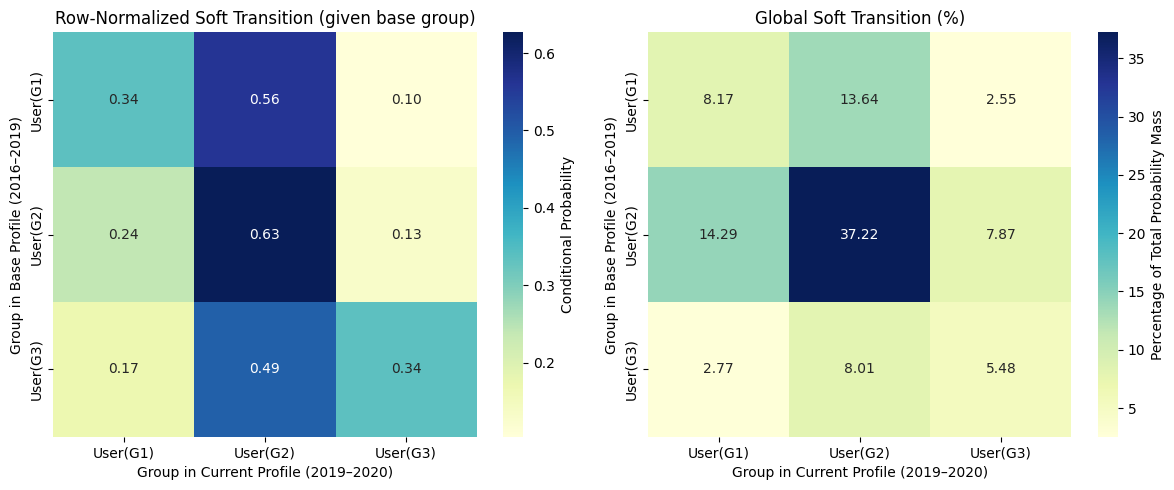

In [50]:
group_labels = [f"User(G{i+1})" for i in range(n_groups)]

# ----------------------------------------------------------
# 1. Compute soft transition matrix (expected probability mass)
# ----------------------------------------------------------
transition_matrix_soft = p_c_ordered.T @ q_c_ordered  # (n_groups × n_groups)

# ----------------------------------------------------------
# 2. Normalize (optional)
# Choose one of the following normalizations:

# (a) Row-wise (conditional: given base group i, where does it go?)
transition_matrix_soft_row = transition_matrix_soft / transition_matrix_soft.sum(axis=1, keepdims=True)

# (b) Global (so total sum = 1, like global proportion)
transition_matrix_soft_global = transition_matrix_soft / transition_matrix_soft.sum()

# ----------------------------------------------------------
# 3. Plot both to compare
# ----------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

df_row = pd.DataFrame(transition_matrix_soft_row, index=group_labels, columns=group_labels)
df_global = pd.DataFrame(transition_matrix_soft_global, index=group_labels, columns=group_labels)

sns.heatmap(df_row, annot=True, fmt=".2f", cmap="YlGnBu",
            ax=axes[0], cbar_kws={"label": "Conditional Probability"})
axes[0].set_title("Row-Normalized Soft Transition (given base group)")
axes[0].set_ylabel("Group in Base Profile (2016–2019)")
axes[0].set_xlabel("Group in Current Profile (2019–2020)")

sns.heatmap(df_global * 100, annot=True, fmt=".2f", cmap="YlGnBu",
            ax=axes[1], cbar_kws={"label": "Percentage of Total Probability Mass"})
axes[1].set_title("Global Soft Transition (%)")
axes[1].set_ylabel("Group in Base Profile (2016–2019)")
axes[1].set_xlabel("Group in Current Profile (2019–2020)")

plt.tight_layout()
plt.show()

C:\Users\sazeh\AppData\Local\Temp\ipykernel_6344\1833087374.py:28: RuntimeWarning: invalid value encountered in divide
  transition_matrix /= transition_matrix.sum(axis=1, keepdims=True)


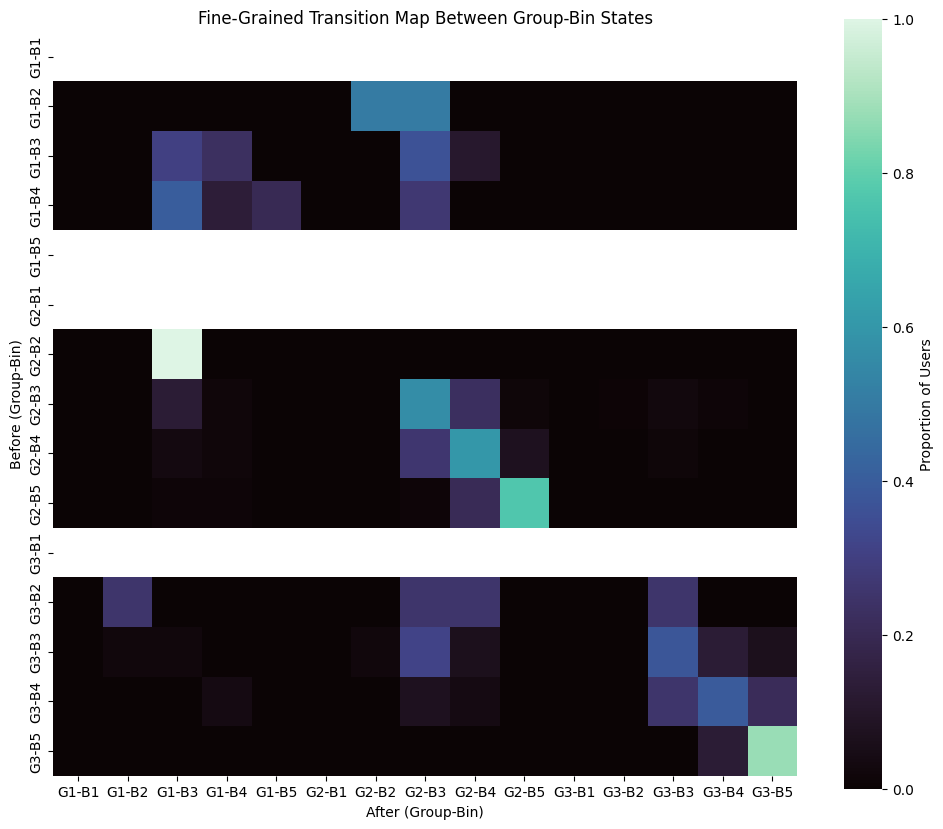

In [57]:
n_bins = 5
bin_edges = np.linspace(0, 1, n_bins + 1)

num_users = p_c_ordered.shape[0]

# Assign each user's group and bin (before & after)
group_before = np.argmax(p_c_ordered, axis=1)
group_after = np.argmax(q_c_ordered, axis=1)

bin_before = np.array([
    np.digitize(p_c_ordered[i, group_before[i]], bin_edges, right=True) - 1
    for i in range(num_users)
])
bin_after = np.array([
    np.digitize(q_c_ordered[i, group_after[i]], bin_edges, right=True) - 1
    for i in range(num_users)
])

# Transition matrix (group-bin to group-bin)
transition_matrix = np.zeros((n_groups * n_bins, n_groups * n_bins))

for i in range(num_users):
    from_idx = group_before[i] * n_bins + bin_before[i]
    to_idx = group_after[i] * n_bins + bin_after[i]
    transition_matrix[from_idx, to_idx] += 1

# Normalize to proportions
transition_matrix /= transition_matrix.sum(axis=1, keepdims=True)

# Label axes
labels = [f"G{g+1}-B{b+1}" for g in range(n_groups) for b in range(n_bins)]
df_transition = pd.DataFrame(transition_matrix, index=labels, columns=labels)

plt.figure(figsize=(12, 10))
sns.heatmap(df_transition, cmap="mako", square=True, cbar_kws={"label": "Proportion of Users"})
plt.xlabel("After (Group-Bin)")
plt.ylabel("Before (Group-Bin)")
plt.title("Fine-Grained Transition Map Between Group-Bin States")
plt.show()

<Axes: >

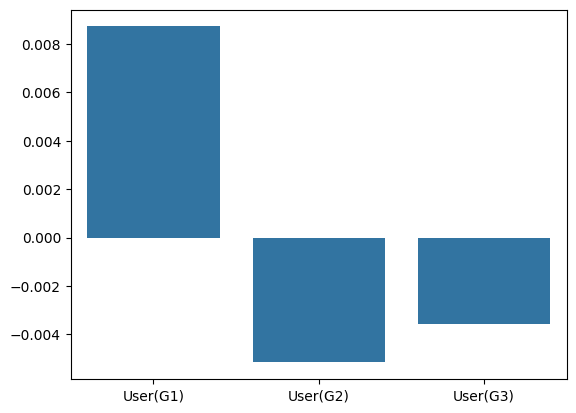

In [58]:
delta = q_c_ordered - p_c_ordered
mean_change = delta.mean(axis=0)
sns.barplot(x=group_labels, y=mean_change)

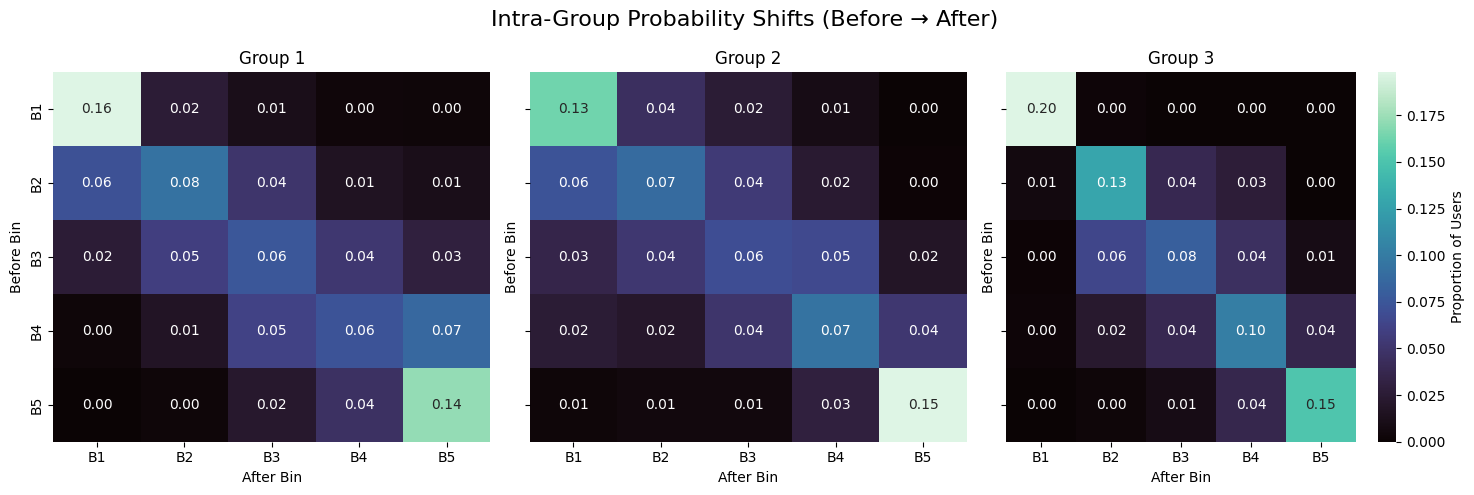

In [62]:
# bin_edges = np.linspace(0, 1, n_bins + 1)

group_labels = [f"Group {i+1}" for i in range(n_groups)]

# Assume p_c_ordered, q_c_ordered are (num_users × n_groups)
num_users = p_c_ordered.shape[0]

fig, axes = plt.subplots(1, n_groups, figsize=(5*n_groups, 5), sharex=True, sharey=True)

for g in range(n_groups):
    bin_edges = np.quantile(p_c_ordered[:, g], np.linspace(0, 1, n_bins+1))
    p_vals = p_c_ordered[:, g]
    q_vals = q_c_ordered[:, g]

    p_bins = np.digitize(p_vals, bin_edges, right=True) - 1
    q_bins = np.digitize(q_vals, bin_edges, right=True) - 1

    # Make sure bins stay in range [0, n_bins-1]
    p_bins = np.clip(p_bins, 0, n_bins - 1)
    q_bins = np.clip(q_bins, 0, n_bins - 1)

    transition = np.zeros((n_bins, n_bins))

    for i in range(num_users):
        transition[p_bins[i], q_bins[i]] += 1

    # Normalize by total users or by row (optional)
    transition /= transition.sum()

    df = pd.DataFrame(transition, 
                      index=[f"B{i+1}" for i in range(n_bins)],
                      columns=[f"B{i+1}" for i in range(n_bins)])

    sns.heatmap(df, ax=axes[g], cmap="mako", annot=True, fmt=".2f",
                cbar=(g == n_groups - 1),  # only show cbar on last plot
                cbar_kws={"label": "Proportion of Users"})
    axes[g].set_title(group_labels[g])
    axes[g].set_xlabel("After Bin")
    axes[g].set_ylabel("Before Bin")

plt.suptitle("Intra-Group Probability Shifts (Before → After)", fontsize=16)
plt.tight_layout()
plt.show()